# Project 4: Cd-Aufnahme über die Nahrung bei Folsomia

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette()
from scipy import stats
import pandas as pd
from copy import deepcopy
import pprint
pp = pprint.PrettyPrinter(indent=2)
import os
import pyarrow

current_dir = os.path.dirname(os.path.abspath(''))
project_directory = os.path.dirname(current_dir)

# automatische aktualisierung externer Python-Dateien
%load_ext autoreload
%autoreload 2 

# Einbindung zusätzlicher Funktionen 
from utils import * 
from ModelFitting import *
from mempyDEB.DEBODE.simulators import *
from mempyDEB.DEBODE.defaultparams import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Start by fitting the model to control data

In [28]:
from DEBfitting_Folsomia import *
data = load_data()
data.head()

,t_day,length_mm,C_F,T_cels,S
85,0,0.609,0,20,1.420620
86,2,0.723,0,20,1.999511
87,4,0.857,0,20,2.805551
88,7,1.019,0,20,3.960986
89,9,1.095,0,20,4.571232


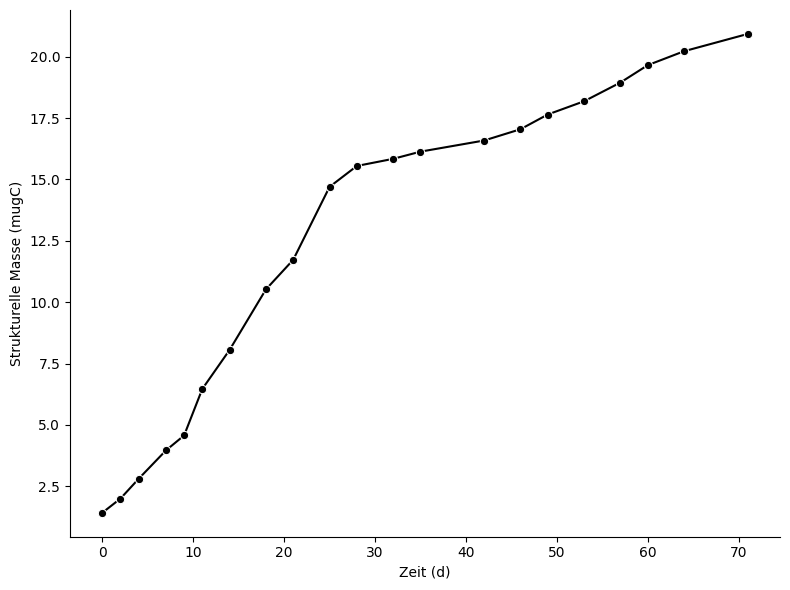

In [29]:
_ = plot_data(data)

c:\Users\Felix\projects\mem25\project\mempyDEB\DEBfitting_Folsomia.py:89: RuntimeWarning: invalid value encountered in scalar power
  p.spc['Idot_max_rel_emb'] *= zoom_factor_theta**(1/3)


Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'Idot_max_rel': np.float64(4.5483797877675745), 'eta_AS_0': np.float64(0.40638832287776183)}


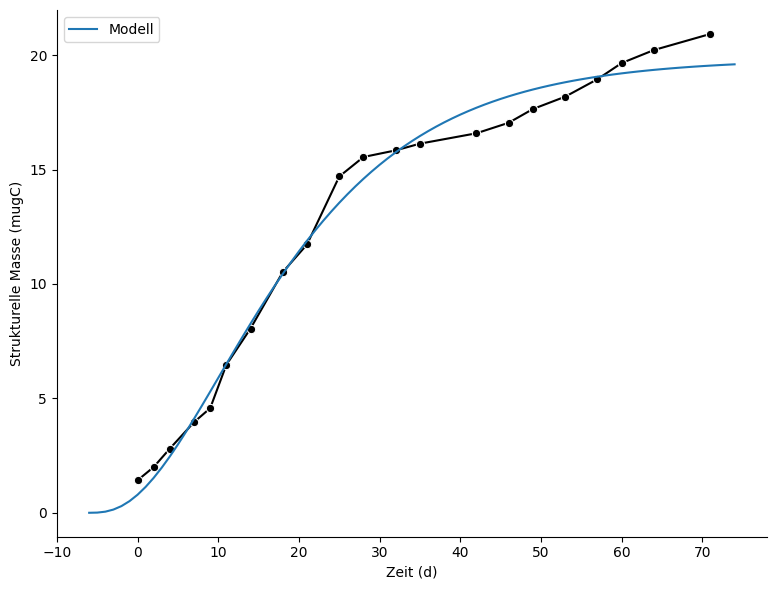

In [30]:
f = fit_model()

c:\Users\Felix\projects\mem25\project\mempyDEB\DEBfitting_Folsomia.py:89: RuntimeWarning: invalid value encountered in scalar power
  p.spc['Idot_max_rel_emb'] *= zoom_factor_theta**(1/3)


Fitted model using Nelder-Mead method. Results stored in `optimization_result`
Estimated parameter values: {'Idot_max_rel': np.float64(4.5483797877675745), 'eta_AS_0': np.float64(0.40638832287776183)}


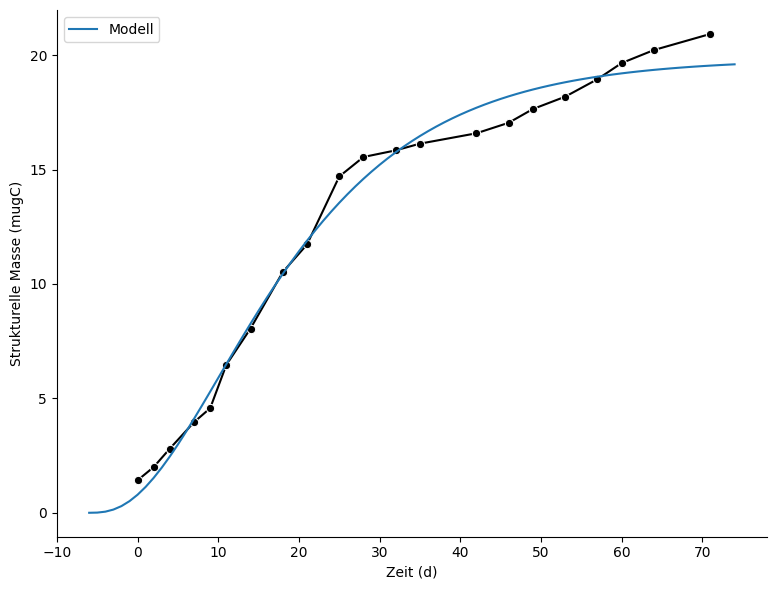

In [31]:
def fit_model_2params():
    """
    DEB-Modellkalibrierung mit zwei Parametern.
    """

    # Definition des ModelFit - Objektes wie zuvor
    f = setup_modelfit() 
    
    # wir müssen hier lediglich den initial guess anpassen
    f.intguess = { 
        'Idot_max_rel' : f.defaultparams.spc['Idot_max_rel'], 
        'eta_AS_0' : f.defaultparams.spc['eta_AS_0']
    }

    # am restlichen Code ändert sich ersmtal nichts

    f.run_optimization()

    print(f"Estimated parameter values: {f.p_opt}")

    # simulate optimized parameters, 

    p = deepcopy(f.defaultparams)
    p.spc.update(f.p_opt)  

    sim_opt = f.simulator(p.spc)

    # plot data + retrodiction

    fig, ax = plot_data(f.data)

    sns.lineplot(sim_opt, x = 't_day', y = 'S', ax = ax, label = "Modell")
    #sns.lineplot(sim_opt, x = 't_day', y = 'cum_repro', ax = ax[1])

    #ax[1].legend()

    return f
 
f_2params = fit_model_2params()

control_fitted_params = f_2params.p_opt


In [32]:
control_fitted_params

{'Idot_max_rel': np.float64(4.5483797877675745),
 'eta_AS_0': np.float64(0.40638832287776183)}

### Bayesian Inference

In [33]:
# f.define_lognorm_prior()
# f.run_bayesian_inference(
#     popsize = 35,
#     max_total_nr_simulations = 1_000)

In [34]:
# f.retrodict()
# fig,ax = plot_data(f.data)

# for df in f.retrodictions:
    
#     sns.lineplot(df, x = 't_day', y = 'S', ax = ax, alpha = .2, color = 'gray')

## use control fit to fit TKTD model

In [61]:
from TKTDFitting_Folsomia import *

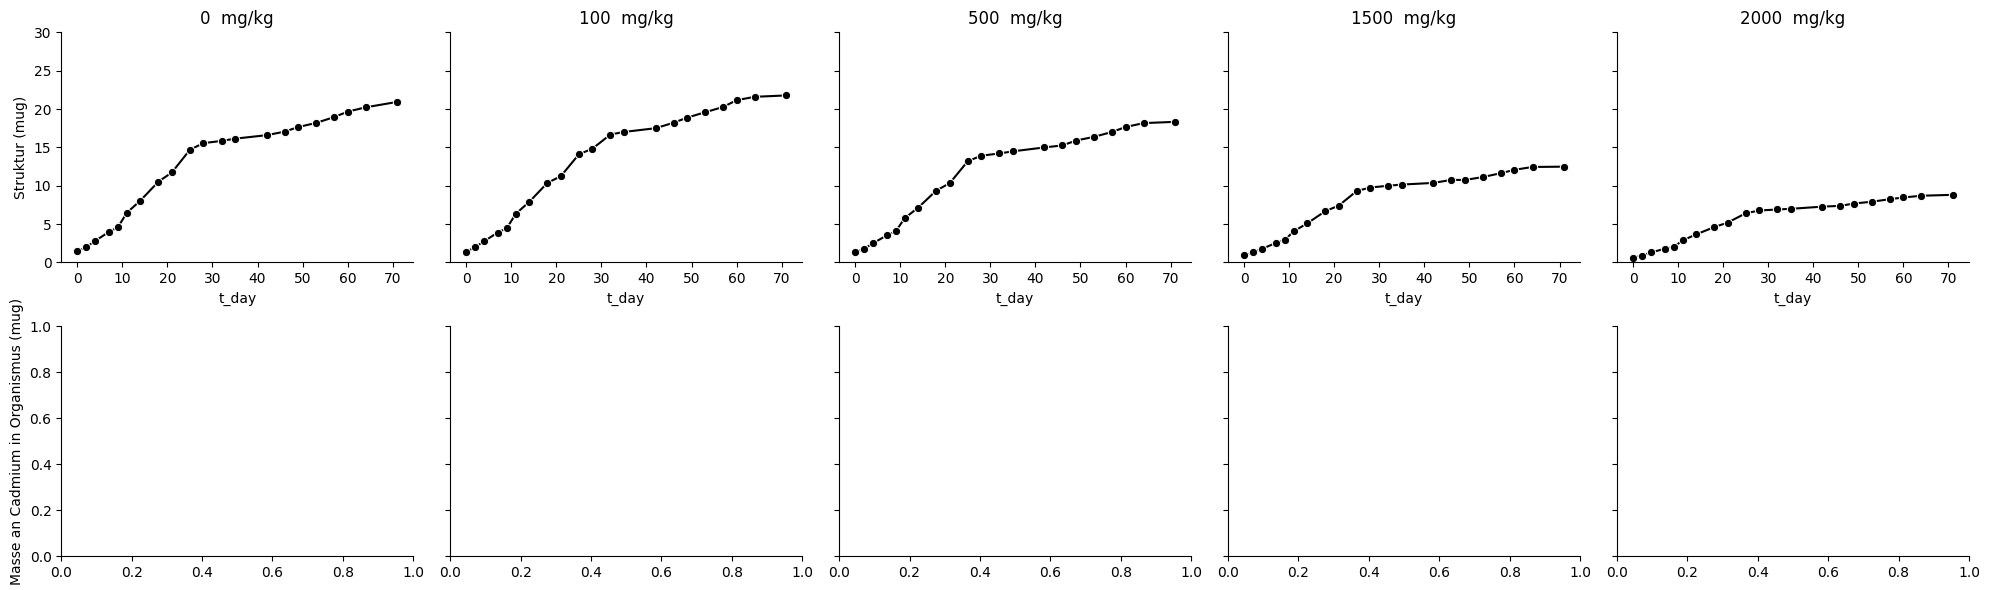

In [62]:
data = load_data()
fig, ax = plot_data(data)


In [ ]:
f = setup_modelfit(pmoa = 'A')
f.defaultparams.spc.update(control_fitted_params)

sim = f.run_optimization() # führe Kalibrierung mittels lokaler Optimisierung durch

print(f"Estimated parameter values: {f.p_opt}")
# Simulation optimisierter Parameter
p = deepcopy(f.defaultparams)
p.spc.update(f.p_opt)  
sim_opt = f.simulator(p.spc)

# Visual predictive check

fig, ax = plot_data(f.data)
ax = plot_sim(ax, sim_opt)

In [ ]:
f.run_optimization()

In [ ]:
sim_intguess = sim_intguess.assign(cd_conc = lambda df : df.Cd_in / df.S)
sim_intguess

,t_day,C_W,level_2,S,R,X_emb,X,D_j,Cd_in,cum_repro,S_ref,R_ref,X_emb_ref,X_ref,D_j_ref,Cd_in_ref,C_W_ref,cum_repro_ref,y_S,cd_conc
0,-6,0,0,0.000010,0.000000,0.947845,3596.296296,0.000000,0.000000,0.0,0.000010,0.000000,0.947845,3596.296296,0.0,0.0,0,0.0,1.000000,0.000000
1,-6,100,81,0.000010,0.000000,0.947845,3596.296296,0.000000,0.000000,51.0,0.000010,0.000000,0.947845,3596.296296,0.0,0.0,0,0.0,1.000000,0.000000
2,-6,500,162,0.000010,0.000000,0.947845,3596.296296,0.000000,0.000000,28.0,0.000010,0.000000,0.947845,3596.296296,0.0,0.0,0,0.0,1.000000,0.000000
3,-6,1500,243,0.000010,0.000000,0.947845,3596.296296,0.000000,0.000000,0.0,0.000010,0.000000,0.947845,3596.296296,0.0,0.0,0,0.0,1.000000,0.000000
4,-6,2000,324,0.000010,0.000000,0.947845,3596.296296,0.000000,0.000000,0.0,0.000010,0.000000,0.947845,3596.296296,0.0,0.0,0,0.0,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,74,0,80,19.590473,49.991862,-0.000121,279701.970763,0.000000,0.000000,50.0,19.590473,49.991862,-0.000121,279701.970763,0.0,0.0,0,50.0,1.000000,0.000000
401,74,100,161,9.889574,26.597512,-0.000121,279973.543600,0.513054,0.511146,28.0,19.590473,49.991862,-0.000121,279701.970763,0.0,0.0,0,50.0,0.504815,0.051685
402,74,500,242,1.915871,0.000000,-0.000121,280732.535345,1.097552,1.086176,0.0,19.590473,49.991862,-0.000121,279701.970763,0.0,0.0,0,50.0,0.097796,0.566936
403,74,1500,323,0.606330,0.000000,-0.000120,281126.636656,1.492925,1.482780,0.0,19.590473,49.991862,-0.000121,279701.970763,0.0,0.0,0,50.0,0.030950,2.445500


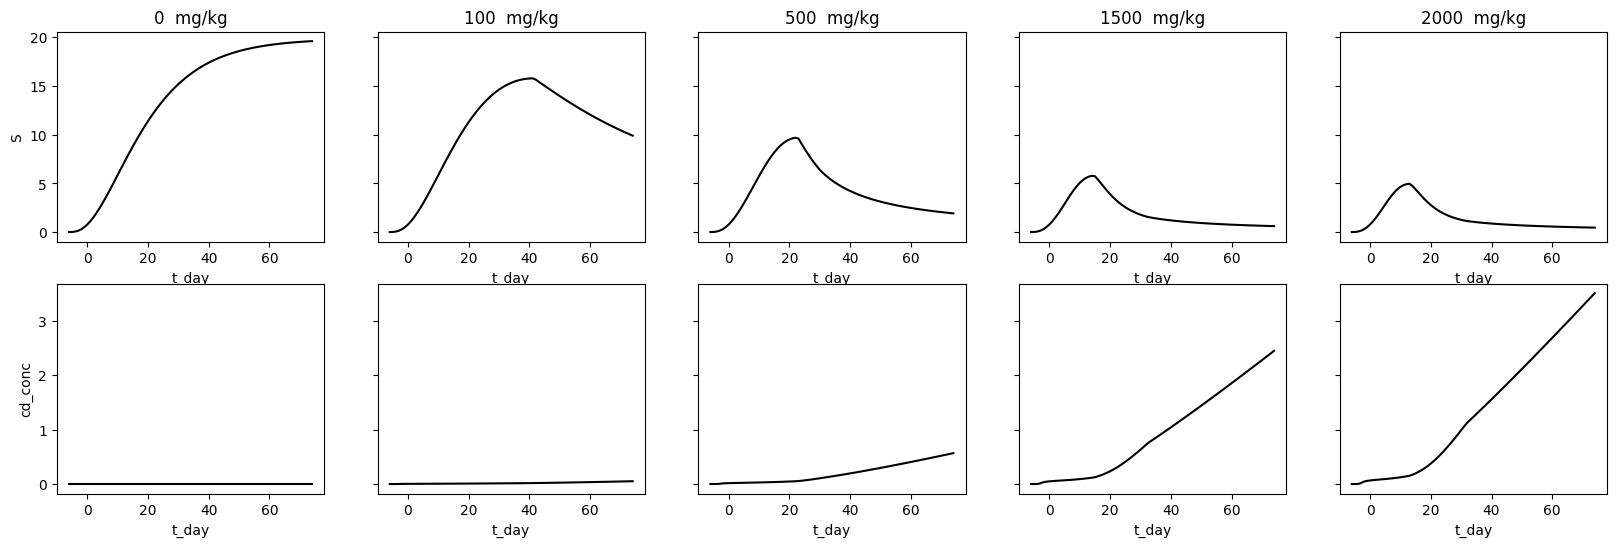

In [49]:
fig, ax = plt.subplots(ncols = 5, nrows=2, figsize = (20,6), sharey = 'row')

for (i,C_W) in enumerate(sim_intguess.C_W.unique()):

    ax[0,i].set(title = f'{C_W}  mg/kg')
    obs = sim_intguess.loc[lambda df : df.C_W==C_W]
    
    sns.lineplot(obs, x = 't_day', y = 'S', ax = ax[0,i], color = 'black')
    sns.lineplot(obs, x = 't_day', y = 'cd_conc', ax = ax[1,i], color = 'black')
    

## trying out different PMoA

## fitting different levels of Cd-exposition from food ingestion/assimilation